<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/Fashion_MNIST_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


So... I've already worked with MNIST. But now I want to refresh it and write code by myself. <br>
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png'>

In [2]:
from keras.datasets.fashion_mnist import load_data

In [3]:
(X_train, _), (X_test, _) = load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [5]:
import matplotlib.pyplot as plt

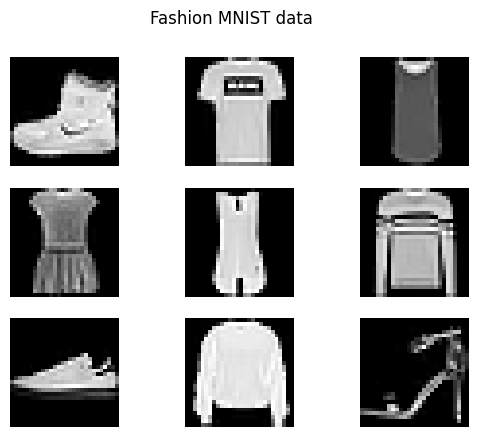

In [6]:
plt.suptitle('Fashion MNIST data')
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(X_train[i], cmap='gray');

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
X_train.max()

1.0

In [9]:
img_size = X_train.shape[1:]
latent_dims = 3

In [10]:
X_train = X_train.reshape(X_train.shape[0], img_size[0], img_size[1], 1)
X_test = X_test.reshape(X_test.shape[0], img_size[0], img_size[1], 1)

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
import tensorflow.keras.backend as K
from tensorflow import keras

I've made special paper with VAE scheme and info
It'll be on github in this very repository<br>


In [12]:
# encoder part

image_input = Input(shape=img_size + (1,))

x = layers.Conv2D(14, 3, padding='same', activation='relu')(image_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

conv_shape = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

In [13]:
def sample_z(args):
  # building distribution
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [14]:
# latent dimension

z_mu = layers.Dense(latent_dims)(x)
z_sigma = layers.Dense(latent_dims)(x)
z = layers.Lambda(sample_z, output_shape=(latent_dims,))([z_mu, z_sigma])

In [15]:
encoder = Model(image_input, [z_mu, z_sigma, z], name='encoder')

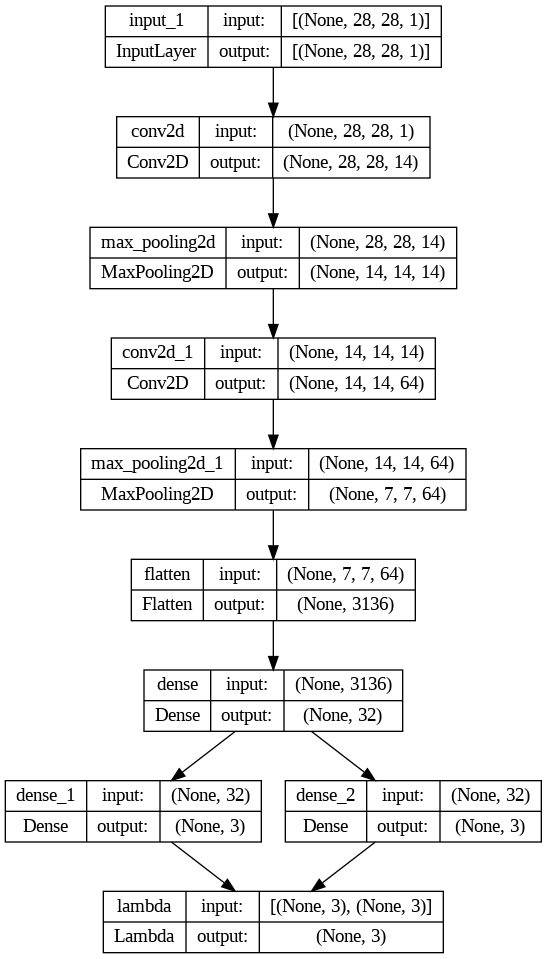

In [16]:
keras.utils.plot_model(encoder, show_shapes=True)

In [17]:
# decoder part

decoder_input = Input(shape=(latent_dims,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3])(decoder_input)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

x = layers.Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2DTranspose(14, 3, padding='same', activation='relu', strides=(2, 2))(x)
output = layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, output)

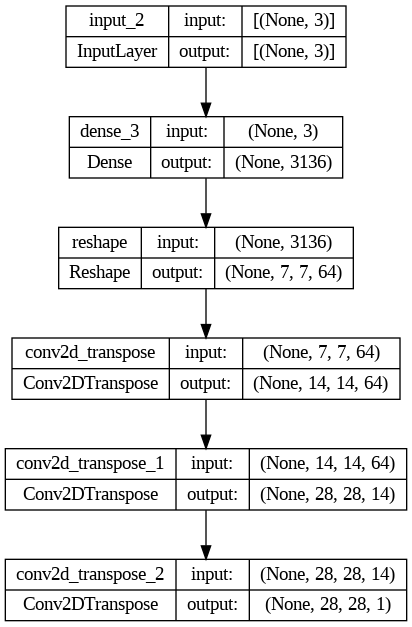

In [18]:
keras.utils.plot_model(decoder, show_shapes=True)

In [19]:
z_decoded = decoder(z)

In [20]:
class LossLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [21]:
y = LossLayer()([image_input, z_decoded])

In [22]:
vae = Model(image_input, y)

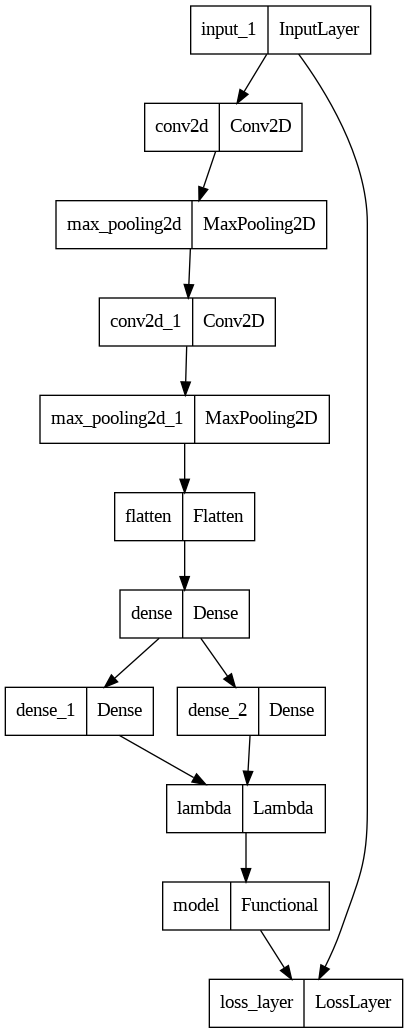

In [23]:
keras.utils.plot_model(vae)

In [24]:
vae.compile(
    optimizer='adam',
    loss=None
)

In [25]:
hist = vae.fit(
    X_train, None,
    batch_size=64,
    epochs=15,
    verbose=2,
    validation_split=0.2
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 - 16s - loss: 0.3719 - val_loss: 0.3308 - 16s/epoch - 328us/sample
Epoch 2/15
48000/48000 - 4s - loss: 0.3241 - val_loss: 0.3219 - 4s/epoch - 75us/sample
Epoch 3/15
48000/48000 - 3s - loss: 0.3193 - val_loss: 0.3196 - 3s/epoch - 68us/sample
Epoch 4/15
48000/48000 - 4s - loss: 0.3172 - val_loss: 0.3180 - 4s/epoch - 88us/sample
Epoch 5/15
48000/48000 - 3s - loss: 0.3158 - val_loss: 0.3167 - 3s/epoch - 68us/sample
Epoch 6/15
48000/48000 - 3s - loss: 0.3149 - val_loss: 0.3162 - 3s/epoch - 68us/sample
Epoch 7/15
48000/48000 - 4s - loss: 0.3141 - val_loss: 0.3153 - 4s/epoch - 76us/sample
Epoch 8/15
48000/48000 - 3s - loss: 0.3135 - val_loss: 0.3150 - 3s/epoch - 69us/sample
Epoch 9/15
48000/48000 - 3s - loss: 0.3130 - val_loss: 0.3143 - 3s/epoch - 68us/sample
Epoch 10/15
48000/48000 - 3s - loss: 0.3126 - val_loss: 0.3143 - 3s/epoch - 72us/sample
Epoch 11/15
48000/48000 - 4s - loss: 0.3121 - val_loss: 0.3137 - 4s/epoch - 75us/sample
Epoch 12/15
48000/48000 - 3s - loss: 0.3118 - val

In [26]:
vae.evaluate(X_test)

0.31357843313217165

In [27]:
pred = vae.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


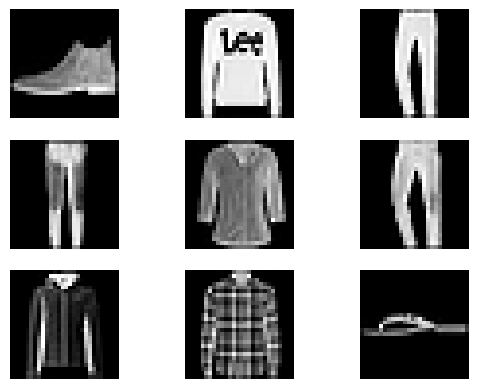

In [28]:
for i in range(9):
  plt.subplot(3, 3, i + 1)
  plt.axis('off')
  plt.imshow(pred[i], cmap='gray');

DAAAAAAAAAAAAAAAAAAAAAAAAAAAAMN <br>
So cool!!!

In [31]:
import numpy as np

In [38]:
def vae_generate_images(new_to_show=10):
    random_codes = np.random.normal(size=(new_to_show, 3))
    new_faces = decoder.predict(np.array(random_codes))

    fig = plt.figure(figsize=(30, 15))

    for i in range(new_to_show):
        ax = fig.add_subplot(6, 10, i+1)
        ax.imshow(new_faces[i], cmap='gray')
        ax.axis('off')
    plt.show()

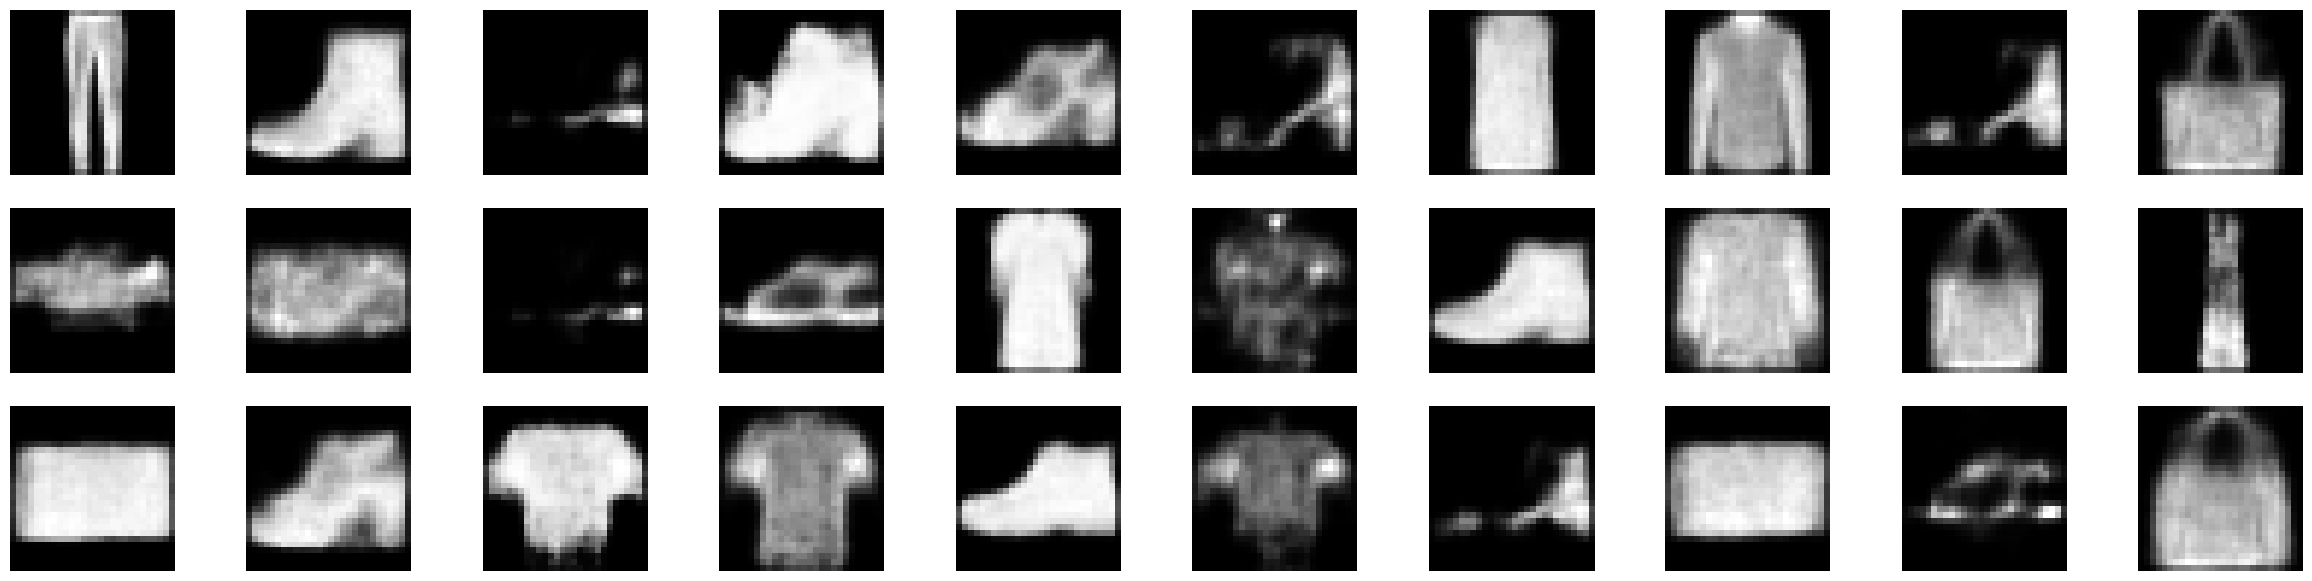

In [39]:
vae_generate_images(30)

That's how Nike make their design...<br>
It's awesome...<br>
Damn<br>
<img src='https://preview.redd.it/delete-the-master-branch-v0-yy04ziaav21c1.jpeg?auto=webp&s=e5a9c17844d04be36be8392c00c47aeaead3b630'>

Ok. Now about the paper:<br>
Here's the <a href='https://drive.google.com/file/d/1IwGCEAaagWXfIXa98kvzHON01EMsn3K1/view?usp=sharing'>link</a><br>
I made it in <a href='https://miro.com/'>Miro</a><br>
If you are aware of virus - you can scan it with <a href='https://www.virustotal.com/gui/home/upload'>VirusTotal</a><br>

I'm a bad coder who doesn't write docs and uploads shitty code<br>
<img src='https://media.tenor.com/jyJYMgUHercAAAAi/thedeep.gif'>